In [1]:
# Build a visual recommender using PCA and TSNE

# Visualizations gebaseerd op: 
# http://joelgrus.com/2013/06/24/t-shirts-feminism-parenting-and-data-science-part-2-eigenshirts/
# https://github.com/joelgrus/shirts
# https://github.com/joelgrus/shirts/blob/master/visuals.py

# What it does: 
# - Break down of Suit Supply shirts into x >= 10 PCA-components
# - Then apply TSNE to get 2 coordinates
# - Visualize the TSNE for every shirt in 2 dimensional space
# - Use Nearest Neighbors to see which shirts are closest to each other (and visualize)

In [44]:
from glob import glob

from scipy.misc import imresize
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from PIL import Image

In [5]:
# glob makes a list of location of shirt images
shirts = glob('images/*jpg')
shirts[0:2]

['shirts/Shirts_Antra_Check_Single_Cuff_H5226_Suitsupply_Online_Store_1.jpg',
 'shirts/Shirts_Blue_Check_Double_Cuff_H5155_Suitsupply_Online_Store_1.jpg']

In [7]:
# all shirt images have this shape: 542, 440, 3
plt.imread(shirts[0]).shape

(542, 440, 3)

In [8]:
# convert 156 shirt images to numpy arry and resize them to get dimension size down
images = [imresize(plt.imread(image), (271,220)) for image in shirts]
print(len(images), type(images[0]), images[0].dtype)

156 <class 'numpy.ndarray'> uint8


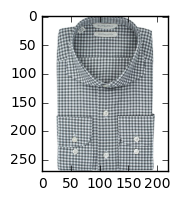

In [10]:
# example of first image
plt.figure(figsize=(2,2))
plt.imshow(images[0])

In [11]:
# convert list of images to a numpy array
images_np = np.array(images)

In [12]:
# compute the mean of all shirt images and the standard deviation
mean = np.mean(images_np, axis=0).astype(np.uint8)
std = np.std(images_np, axis=0).astype(np.uint8)

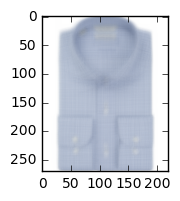

In [13]:
# show the mean shirt image
plt.figure(figsize=(2,2))
plt.imshow(mean)

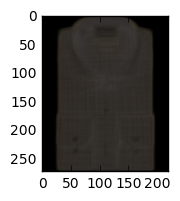

In [14]:
# show the standard deviation of the shirt images
plt.figure(figsize=(2,2))
plt.imshow(std)

In [15]:
# flatten every image to a vector of size 1 * (271*220*3) 
images_flatten = [imresize(plt.imread(image), (271,220)).flatten() for image in shirts]
images_flatten = np.array(images_flatten)
images_flatten.shape

(156, 178860)

In [31]:
# calculate the principal components of the shirts
pca = PCA(n_components=25)
images_pca = pca.fit_transform(images_flatten)
sum(pca.explained_variance_ratio_)

0.9197655805516004

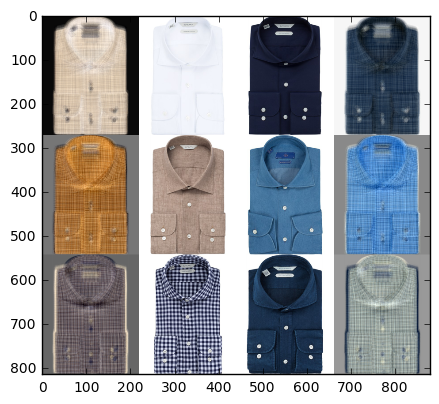

In [21]:
# function to create shirt from 1 component
# and show what the typical shirt is for that component (and which is most atypical)

def image_from_component(component):
    """takes one of the principal components and turns it into an image"""
    hi = max(component)
    lo = min(component)
    n = len(component) / 3
    def rescale(x):
        return int(255 * (x - lo) / (hi - lo))
    d = [(rescale(component[3 * i])
          ,
          rescale(component[3 * i + 1]),
          rescale(component[3 * i + 2])
         ) for i in range(int(n))]
    img = np.array(d)
    img = img.reshape((271,220,3))
    return img

result = np.empty((1,220*4,3), dtype=int)

#for the first x components, show the eigenvalues, show what the component looks like
for i, component in enumerate(pca.components_[0:3]):
    global result
    img = image_from_component(component)
    reverse_img2 = abs(img - 255) 
    idx_max = np.argmax(images_pca[:,i])

    idx_min = np.argmin(images_pca[:,i])

    eigen_and_inverse = np.concatenate((img, images_np[idx_max], images_np[idx_min], reverse_img2), axis=1)
    result = np.concatenate((result, eigen_and_inverse), axis=0)

plt.figure(figsize=(5,5))
plt.imshow(result.astype(np.uint8))

In [52]:
# use TSNE to convert the images two only 2 dimensions
tsne = TSNE()
imgs_tsne = tsne.fit_transform(images_pca)
imgs_tsne[0:3]

array([[-46.17333555, -73.56027792],
       [-42.80337563,   5.0753617 ],
       [ 50.50652873, -26.79412973]])

In [33]:
# create thumbnails to use those in the TSNE 2D visualization
images_thumb = [imresize(plt.imread(image), (40,35)) for image in shirts]

In [53]:
# calculate the ranges from x and y coordinates that TSNE creates
min_x_y = np.min(imgs_tsne,axis=0)
max_x_y = np.max(imgs_tsne,axis=0)
range_x_y = np.max(imgs_tsne,axis=0) - np.min(imgs_tsne,axis=0)
print(min_x_y, max_x_y, range_x_y)

[-77.56911787 -81.71301535] [ 99.70311198  78.75604408] [ 177.27222985  160.46905943]


In [54]:
# set up an empty canvas to place the thumbnails in
empty_picture = np.full((range_x_y[0]*5,range_x_y[1]*5,3), 255).astype(np.uint8)

/Users/svandenoord/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:297: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/svandenoord/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((886.3611492589074, 802.34529716479574, 3), 255) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [55]:
# start placing in empty thumbnails in the empty 2D canvas
for i in range(len(images)):
    x = (imgs_tsne[i][0] - min_x_y[0]) / range_x_y[0]
    y = (imgs_tsne[i][1] - min_x_y[1]) / range_x_y[1]
    x_new = empty_picture.shape[0] * x - 50
    if x_new < 0: x_new = 0
    x_new = int(x_new)
    y_new = empty_picture.shape[1] * y - 50
    if y_new < 0: y_new = 0
    y_new = int(y_new)
    empty_picture[x_new:x_new+images_thumb[i].shape[0], y_new:y_new+images_thumb[i].shape[1]] = images_thumb[i]

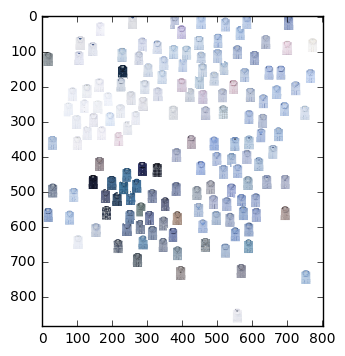

In [56]:
plt.figure(figsize=(4,4))
plt.imshow(empty_picture)

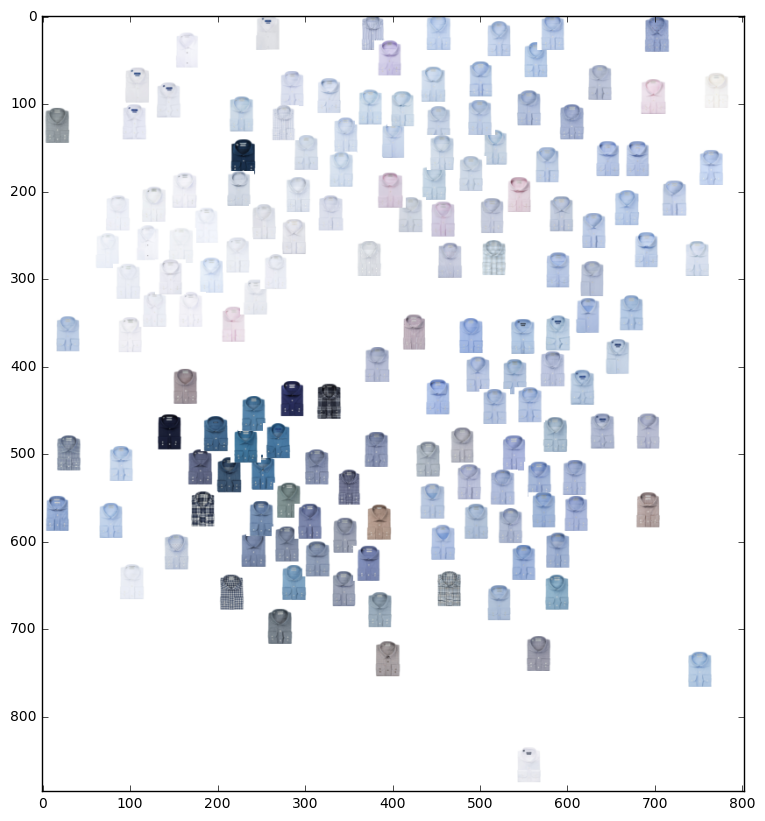

In [57]:
# throw out most of the empty space
empty_picture_crop = empty_picture[:,:,:]
plt.figure(figsize=(10,10))
plt.imshow(empty_picture_crop)

In [58]:
# save the image
im = Image.fromarray(empty_picture_crop)
im.save("visualization_shirts_crop2.jpeg")

In [59]:
# since we now have 2D, we can calculate nearest neighbors with Euclidean distance
neigh = NearestNeighbors()
neigh.fit(imgs_tsne)
distance, index = neigh.kneighbors(imgs_tsne,return_distance=True)
index[15:20]

array([[ 15,  19,   9,  30,  72],
       [ 16,  11,  47, 112,  34],
       [ 17, 112, 118,  47, 106],
       [ 18, 129, 103, 113,  29],
       [ 19,   9,  34,  15, 115]])

In [60]:
first_recos = np.empty((1,220*5,3)).astype(np.uint8)

for i in index[5:10]:
    near_neighbors = np.concatenate((images_np[index[i][0][0]], 
                                     images_np[index[i][0][1]], 
                                     images_np[index[i][0][2]],
                                     images_np[index[i][0][3]],
                                     images_np[index[i][0][4]]), axis=1)
    first_recos = np.concatenate((first_recos, near_neighbors), axis=0)

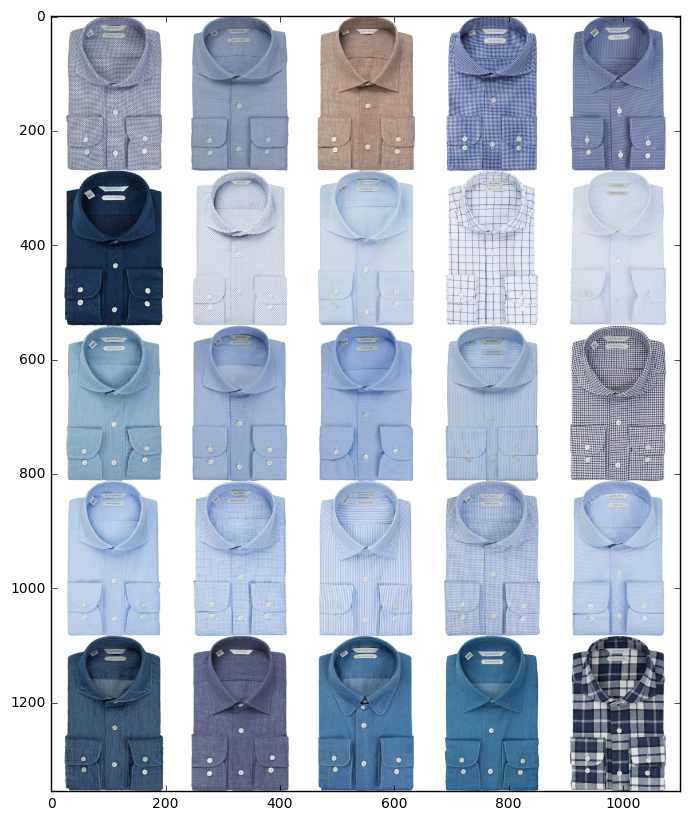

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(first_recos)